# Import the Basic Packages

In [186]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import datetime as dt
%matplotlib inline
import math
import pandas_profiling
from sklearn.model_selection import train_test_split
from sklearn import metrics

from patsy import dmatrices
from statsmodels.stats.outliers_influence import variance_inflation_factor

from sklearn.linear_model import LogisticRegression

print(pd.__version__)
print(np.__version__)
print(sns.__version__)

0.25.3
1.16.5
0.9.0


## Create UDF's

In [187]:
# Create Data audit Report for continuous variables
def continuous_var_summary(x):
    return pd.Series([
        x.count(),
        x.isnull().sum(),
        x.sum(),
        x.mean(),
        x.median(),
        x.std(),
        x.var(),
        x.min(),
        x.quantile(0.01),
        x.quantile(0.05),
        x.quantile(0.10),
        x.quantile(0.25),
        x.quantile(0.50),
        x.quantile(0.75),
        x.quantile(0.90),
        x.quantile(0.95),
        x.quantile(0.99),
        x.max()
    ],
                     index=[
                         'N', 'NMISS', 'SUM', 'MEAN', 'MEDIAN', 'STD', 'VAR',
                         'MIN', 'P1', 'P5', 'P10', 'P25', 'P50', 'P75', 'P90',
                         'P95', 'P99', 'MAX'
                     ])

In [188]:
# Create Data audit Report for categorical variables
def categorical_var_summary(x):
    Mode = x.value_counts().sort_values(ascending=False)[0:1].reset_index()
    return pd.Series([
        x.count(),
        x.isnull().sum(), Mode.iloc[0, 0], Mode.iloc[0, 1],
        round(Mode.iloc[0, 1] * 100 / x.count(), 2)
    ],
                     index=['N', 'NMISS', 'MODE', 'FREQ', 'PERCENT'])

In [189]:
# Missing value imputation for categorical and continuous variables
def missing_imputation(x, stats='mean'):
    if (x.dtypes == 'float64') | (x.dtypes == 'int64'):
        x = x.fillna(x.mean()) if stats == 'mean' else x.fillna(x.median())
    else:
        x = x.fillna(x.mode())
    return x 

In [190]:
#An utility function to create dummy variable
def create_dummies(df, colname):
    col_dummies = pd.get_dummies(df[colname], prefix=colname, drop_first=True)
    df = pd.concat([df, col_dummies], axis=1)
    df.drop(colname, axis=1, inplace=True)
    return df

In [191]:
# create user defined function to create the freq plots
def fn_countplot(pd_series):
    plt.figure(figsize=(5, 3))
    sns.countplot(y=pd_series)
    print('This is a freq chart for ' + pd_series.name)
    plt.show()
    return

In [192]:
# attach the column names to the dataset

col_names = [
    "duration", "protocol_type", "service", "flag", "src_bytes", "dst_bytes",
    "land", "wrong_fragment", "urgent", "hot", "num_failed_logins",
    "logged_in", "num_compromised", "root_shell", "su_attempted", "num_root",
    "num_file_creations", "num_shells", "num_access_files",
    "num_outbound_cmds", "is_host_login", "is_guest_login", "count",
    "srv_count", "serror_rate", "srv_serror_rate", "rerror_rate",
    "srv_rerror_rate", "same_srv_rate", "diff_srv_rate", "srv_diff_host_rate",
    "dst_host_count", "dst_host_srv_count", "dst_host_same_srv_rate",
    "dst_host_diff_srv_rate", "dst_host_same_src_port_rate",
    "dst_host_srv_diff_host_rate", "dst_host_serror_rate",
    "dst_host_srv_serror_rate", "dst_host_rerror_rate",
    "dst_host_srv_rerror_rate", "attack", "last_flag"
]

df_train = pd.read_table(
    'C:/Data Sets/(Class 21-Python - Case Study)/3. Network Intrusion Detection System/NSL_Dataset/train.txt',
    names=col_names,  #Adding the column names
    index_col=False,      #Removing the first column values from becoming an index.
    sep=','                      #Separator used to separate the values and create a readable DataFrame
)  
df_test = pd.read_table(
    'C:/Data Sets/(Class 21-Python - Case Study)/3. Network Intrusion Detection System/NSL_Dataset/test.txt',
    names=col_names,   #Adding the column names for the test dataset
    index_col=False,       #Removing the first column values from becoming an index for the test dataset
    sep=',')                      #Separator used to separate the values and create a readable DataFrame for the test dataset

# shape, this gives the dimensions of the dataset
print('Dimensions of the Training set:', df_train.shape)
print('Dimensions of the Test set:', df_test.shape)

Dimensions of the Training set: (125973, 43)
Dimensions of the Test set: (22544, 43)


In [193]:
df_train.head()  #First 5 values for basic assesment.

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,attack,last_flag
0,0,tcp,ftp_data,SF,491,0,0,0,0,0,...,0.17,0.03,0.17,0.00,0.00,0.00,0.05,0.00,normal,20
1,0,udp,other,SF,146,0,0,0,0,0,...,0.00,0.60,0.88,0.00,0.00,0.00,0.00,0.00,normal,15
2,0,tcp,private,S0,0,0,0,0,0,0,...,0.10,0.05,0.00,0.00,1.00,1.00,0.00,0.00,neptune,19
3,0,tcp,http,SF,232,8153,0,0,0,0,...,1.00,0.00,0.03,0.04,0.03,0.01,0.00,0.01,normal,21
4,0,tcp,http,SF,199,420,0,0,0,0,...,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,normal,21


In [304]:
df_test.head()

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,attack,last_flag
0,0,tcp,private,REJ,0,0,0,0,0,0,...,0.04,0.06,0.00,0.00,0.0,0.0,1.00,1.00,1,21
1,0,tcp,private,REJ,0,0,0,0,0,0,...,0.00,0.06,0.00,0.00,0.0,0.0,1.00,1.00,1,21
2,2,tcp,ftp_data,SF,12983,0,0,0,0,0,...,0.61,0.04,0.61,0.02,0.0,0.0,0.00,0.00,0,21
3,0,icmp,eco_i,SF,20,0,0,0,0,0,...,1.00,0.00,1.00,0.28,0.0,0.0,0.00,0.00,2,15
4,1,tcp,telnet,RSTO,0,15,0,0,0,0,...,0.31,0.17,0.03,0.02,0.0,0.0,0.83,0.71,2,11


In [195]:
df_train.info() #Basic Information check for null values and data types.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 125973 entries, 0 to 125972
Data columns (total 43 columns):
duration                       125973 non-null int64
protocol_type                  125973 non-null object
service                        125973 non-null object
flag                           125973 non-null object
src_bytes                      125973 non-null int64
dst_bytes                      125973 non-null int64
land                           125973 non-null int64
wrong_fragment                 125973 non-null int64
urgent                         125973 non-null int64
hot                            125973 non-null int64
num_failed_logins              125973 non-null int64
logged_in                      125973 non-null int64
num_compromised                125973 non-null int64
root_shell                     125973 non-null int64
su_attempted                   125973 non-null int64
num_root                       125973 non-null int64
num_file_creations             125973 

In [196]:
#This is multinomial classification to detect anamolies and attacks in the network.
#Multinomial classification: Activity is Normal or DOS or PROBE or R2L or U2R. Classifying it as 0,1,2,3,4

df_train.loc[df_train.attack == 'normal', 'attack'] = 0  #Normal

df_train.loc[(df_train.attack == 'back') | (df_train.attack == 'land') |  #DOS
             (df_train.attack == 'pod') | (df_train.attack == 'neptune') |
             (df_train.attack == 'smurf') | (df_train.attack == 'teardrop') |
             (df_train.attack == 'apache2') | (df_train.attack == 'udpstorm') |
             (df_train.attack == 'processtable') | (df_train.attack == 'worm')
             | (df_train.attack == 'mailbomb'), 'attack'] = 1

df_train.loc[(df_train.attack == 'satan') | (df_train.attack == 'ipsweep')  #PROBE
             |                                                                                                
             (df_train.attack == 'nmap') | (df_train.attack == 'portsweep') |
             (df_train.attack == 'mscan') | (df_train.attack == 'saint'),
             'attack'] = 2

df_train.loc[(df_train.attack == 'guess_passwd') |  #R2L
             (df_train.attack == 'ftp_write') | (df_train.attack == 'imap') |
             (df_train.attack == 'phf') | (df_train.attack == 'multihop') |
             (df_train.attack == 'warezmaster') |
             (df_train.attack == 'warezclient') | (df_train.attack == 'spy') |
             (df_train.attack == 'xlock') | (df_train.attack == 'xsnoop') |
             (df_train.attack == 'snmpguess') |
             (df_train.attack == 'snmpgetattack') |
             (df_train.attack == 'httptunnel') |
             (df_train.attack == 'sendmail') | (df_train.attack == 'named'),
             'attack'] = 3

df_train.loc[(df_train.attack == 'buffer_overflow') |  #U2R
             (df_train.attack == 'loadmodule') | (df_train.attack == 'rootkit')
             | (df_train.attack == 'perl') | (df_train.attack == 'sqlattack') |
             (df_train.attack == 'xterm') | (df_train.attack == 'ps'),
             'attack'] = 4

df_train.head()

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,attack,last_flag
0,0,tcp,ftp_data,SF,491,0,0,0,0,0,...,0.17,0.03,0.17,0.00,0.00,0.00,0.05,0.00,0,20
1,0,udp,other,SF,146,0,0,0,0,0,...,0.00,0.60,0.88,0.00,0.00,0.00,0.00,0.00,0,15
2,0,tcp,private,S0,0,0,0,0,0,0,...,0.10,0.05,0.00,0.00,1.00,1.00,0.00,0.00,1,19
3,0,tcp,http,SF,232,8153,0,0,0,0,...,1.00,0.00,0.03,0.04,0.03,0.01,0.00,0.01,0,21
4,0,tcp,http,SF,199,420,0,0,0,0,...,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0,21


In [197]:
#We will do the same with the test data

df_test.loc[df_test.attack == 'normal', 'attack'] = 0  #Normal

df_test.loc[(df_test.attack == 'back') | (df_test.attack == 'land') |  #DOS
            (df_test.attack == 'pod') | (df_test.attack == 'neptune') |
            (df_test.attack == 'smurf') | (df_test.attack == 'teardrop') |
            (df_test.attack == 'apache2') | (df_test.attack == 'udpstorm') |
            (df_test.attack == 'processtable') | (df_test.attack == 'worm')
            | (df_test.attack == 'mailbomb'), 'attack'] = 1

df_test.loc[(df_test.attack == 'satan') | (df_test.attack == 'ipsweep')  #PROBE
            | (df_test.attack == 'nmap') | (df_test.attack == 'portsweep') |
            (df_test.attack == 'mscan') | (df_test.attack == 'saint'),
            'attack'] = 2

df_test.loc[(df_test.attack == 'guess_passwd') |  #R2L
            (df_test.attack == 'ftp_write') | (df_test.attack == 'imap') |
            (df_test.attack == 'phf') | (df_test.attack == 'multihop') |
            (df_test.attack == 'warezmaster') |
            (df_test.attack == 'warezclient') | (df_test.attack == 'spy') |
            (df_test.attack == 'xlock') | (df_test.attack == 'xsnoop') |
            (df_test.attack == 'snmpguess') |
            (df_test.attack == 'snmpgetattack') |
            (df_test.attack == 'httptunnel') | (df_test.attack == 'sendmail') |
            (df_test.attack == 'named'), 'attack'] = 3

df_test.loc[(df_test.attack == 'buffer_overflow') |  #U2R
            (df_test.attack == 'loadmodule') | (df_test.attack == 'rootkit')
            | (df_test.attack == 'perl') | (df_test.attack == 'sqlattack') |
            (df_test.attack == 'xterm') | (df_test.attack == 'ps'),
            'attack'] = 4

df_test.head()

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,attack,last_flag
0,0,tcp,private,REJ,0,0,0,0,0,0,...,0.04,0.06,0.00,0.00,0.0,0.0,1.00,1.00,1,21
1,0,tcp,private,REJ,0,0,0,0,0,0,...,0.00,0.06,0.00,0.00,0.0,0.0,1.00,1.00,1,21
2,2,tcp,ftp_data,SF,12983,0,0,0,0,0,...,0.61,0.04,0.61,0.02,0.0,0.0,0.00,0.00,0,21
3,0,icmp,eco_i,SF,20,0,0,0,0,0,...,1.00,0.00,1.00,0.28,0.0,0.0,0.00,0.00,2,15
4,1,tcp,telnet,RSTO,0,15,0,0,0,0,...,0.31,0.17,0.03,0.02,0.0,0.0,0.83,0.71,2,11


In [1]:
#Pandas Profiling for the data
#report1 = pandas_profiling.ProfileReport(df_train)
#report1.to_file(
#    output_file=
#    'C:/Data Sets/(Class 21-Python - Case Study)/3. Network Intrusion Detection System/profilereportmultinomial.html'
#)
#report1

In [198]:
#Separating the categorial and continous variables

df_train_cont = df_train.select_dtypes(['int64','float64']) 
df_train_cat = df_train.select_dtypes(['object'])

df_test_cont = df_test.select_dtypes(['int64','float64']) 
df_test_cat = df_test.select_dtypes(['object'])

In [199]:
df_train_cat.head()

,protocol_type,service,flag
0,tcp,ftp_data,SF
1,udp,other,SF
2,tcp,private,S0
3,tcp,http,SF
4,tcp,http,SF


In [200]:
df_train_cont.head()

,duration,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,...,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,attack,last_flag
0,0,491,0,0,0,0,0,0,0,0,...,0.17,0.03,0.17,0.00,0.00,0.00,0.05,0.00,0,20
1,0,146,0,0,0,0,0,0,0,0,...,0.00,0.60,0.88,0.00,0.00,0.00,0.00,0.00,0,15
2,0,0,0,0,0,0,0,0,0,0,...,0.10,0.05,0.00,0.00,1.00,1.00,0.00,0.00,1,19
3,0,232,8153,0,0,0,0,0,1,0,...,1.00,0.00,0.03,0.04,0.03,0.01,0.00,0.01,0,21
4,0,199,420,0,0,0,0,0,1,0,...,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0,21


In [201]:
#Data report for checking null values and outlier data and summary.

df_train_cont.apply(continuous_var_summary).round(2)

#We found that we have outlier data. We will treat it below.
#There are no null values.

,duration,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,...,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,attack,last_flag
N,125973.00,1.259730e+05,1.259730e+05,125973.00,125973.00,125973.00,125973.00,125973.00,125973.00,125973.00,...,125973.00,125973.00,125973.00,125973.00,125973.00,125973.00,125973.00,125973.00,125973.00,125973.00
NMISS,0.00,0.000000e+00,0.000000e+00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
SUM,36172473.00,5.740179e+09,2.491634e+09,25.00,2858.00,14.00,25750.00,154.00,49852.00,35178.00,...,65662.38,10449.60,18691.73,4099.47,35833.33,35081.53,14969.60,15146.98,72432.00,2456985.00
MEAN,287.14,4.556674e+04,1.977911e+04,0.00,0.02,0.00,0.20,0.00,0.40,0.28,...,0.52,0.08,0.15,0.03,0.28,0.28,0.12,0.12,0.57,19.50
MEDIAN,0.00,4.400000e+01,0.000000e+00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.51,0.02,0.00,0.00,0.00,0.00,0.00,0.00,0.00,20.00
STD,2604.52,5.870331e+06,4.021269e+06,0.01,0.25,0.01,2.15,0.05,0.49,23.94,...,0.45,0.19,0.31,0.11,0.44,0.45,0.31,0.32,0.69,2.29
VAR,6783500.00,3.446079e+13,1.617061e+13,0.00,0.06,0.00,4.62,0.00,0.24,573.22,...,0.20,0.04,0.10,0.01,0.20,0.20,0.09,0.10,0.48,5.25
MIN,0.00,0.000000e+00,0.000000e+00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
P1,0.00,0.000000e+00,0.000000e+00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,11.00
P5,0.00,0.000000e+00,0.000000e+00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,15.00


In [202]:
df_train_cat.apply(categorical_var_summary)

,protocol_type,service,flag
N,125973,125973,125973
NMISS,0,0,0
MODE,tcp,http,SF
FREQ,102689,40338,74945
PERCENT,81.52,32.02,59.49


In [203]:
#We found that we had outlier data in the summary so handling outliers.


def outlier_capping(x):
    x = x.clip(upper=x.quantile(0.99))
    x = x.clip(lower=x.quantile(0.01))
    return x


df_train_cont = df_train_cont.apply(outlier_capping)
df_test_cont = df_test_cont.apply(outlier_capping)

## Basic Exploratory Data Analysis

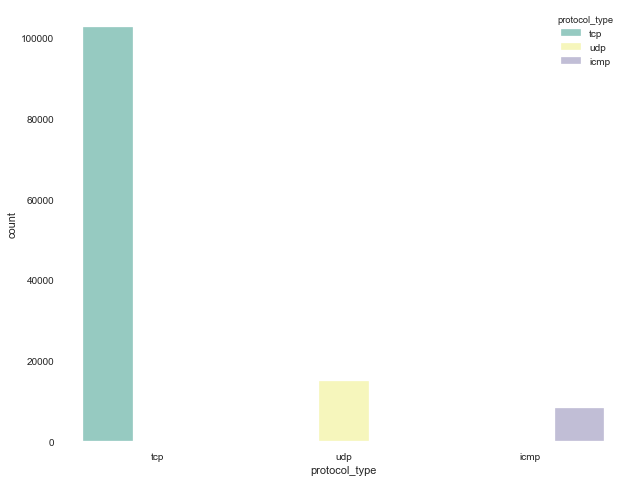

In [204]:
# Protocol type distribution
plt.figure(figsize=(10, 8))
sns.countplot(x="protocol_type",
              data=df_train,
              hue='protocol_type',
              palette="Set3")
plt.show()

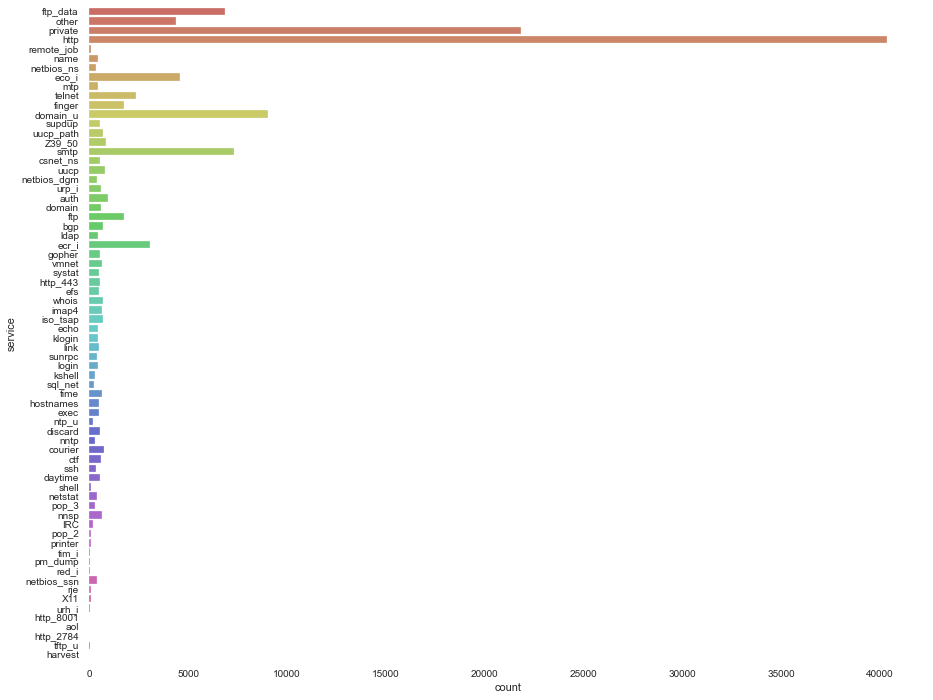

In [205]:
# service distribution
plt.figure(figsize=(15, 12))
sns.countplot(y="service", data=df_train, palette="hls")
plt.show()

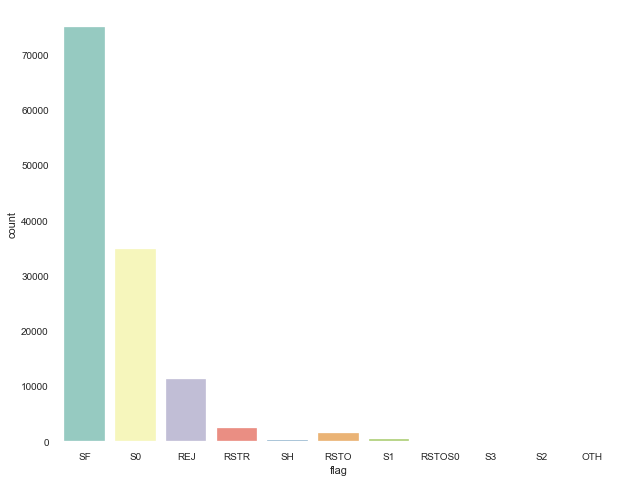

In [206]:
# flag distribution
plt.figure(figsize=(10, 8))
sns.countplot(x="flag", data=df_train, palette="Set3")
plt.show()

In [207]:
#Label column to diagnose the attack values
df_train.attack.value_counts()

0    67343
1    45927
2    11656
3      995
4       52
Name: attack, dtype: int64

0    67343
1    45927
2    11656
3      995
4       52
Name: attack, dtype: int64


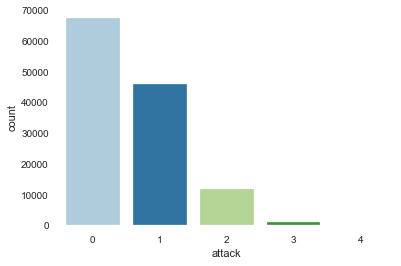

In [208]:
#Checking if the y variable is skewed or not

sns.countplot(x='attack', data=df_train, palette='Paired')

print(df_train.attack.value_counts())

#The y variable is not skewed so we dont need to do sampling of the data.

0    9711
1    7460
3    2885
2    2421
4      67
Name: attack, dtype: int64


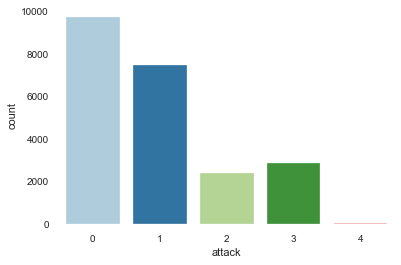

In [209]:
#Checking if the y variable is skewed or not

sns.countplot(x='attack', data=df_test, palette='Paired')

print(df_test.attack.value_counts())

#The y variable is not skewed so we dont need to do sampling of the data.

In [210]:
#Creating Dummy Variables for the nominal categorical variables

cat_dummies = ['protocol_type', 'service', 'flag']
#for c_feature in categorical_features

# for c_feature in categorical_features
for c_feature in [cat_dummies]:
    df_train_cat[c_feature] = df_train_cat[c_feature].astype('category')
    df_train_cat = create_dummies(df_train_cat, c_feature)

C:\Users\shaur\Anaconda3\lib\site-packages\pandas\core\frame.py:3509: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


In [211]:
df_train_cat.head()

,protocol_type_tcp,protocol_type_udp,service_X11,service_Z39_50,service_aol,service_auth,service_bgp,service_courier,service_csnet_ns,service_ctf,...,flag_REJ,flag_RSTO,flag_RSTOS0,flag_RSTR,flag_S0,flag_S1,flag_S2,flag_S3,flag_SF,flag_SH
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
1,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
4,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0


In [212]:
# for c_feature in categorical_features
for c_feature in [cat_dummies]:
    df_test_cat[c_feature] = df_test_cat[c_feature].astype('category')
    df_test_cat = create_dummies(df_test_cat, c_feature)

In [213]:
df_test_cat.head()

,protocol_type_tcp,protocol_type_udp,service_X11,service_Z39_50,service_auth,service_bgp,service_courier,service_csnet_ns,service_ctf,service_daytime,...,flag_REJ,flag_RSTO,flag_RSTOS0,flag_RSTR,flag_S0,flag_S1,flag_S2,flag_S3,flag_SF,flag_SH
0,1,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
4,1,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0


## Final Data for Analysis

In [214]:
df_train_new = pd.concat([df_train_cont, df_train_cat], axis=1)
df_test_new = pd.concat([df_test_cont, df_test_cat], axis=1)

In [215]:
df_train_new.head()

,duration,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,...,flag_REJ,flag_RSTO,flag_RSTOS0,flag_RSTR,flag_S0,flag_S1,flag_S2,flag_S3,flag_SF,flag_SH
0,0.0,491,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
1,0.0,146,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
2,0.0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
3,0.0,232,8153,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,1,0
4,0.0,199,420,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,1,0


In [216]:
df_test_new.head()

,duration,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,...,flag_REJ,flag_RSTO,flag_RSTOS0,flag_RSTR,flag_S0,flag_S1,flag_S2,flag_S3,flag_SF,flag_SH
0,0.0,0,0.0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
1,0.0,0,0.0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
2,2.0,12983,0.0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
3,0.0,20,0.0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
4,1.0,0,15.0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0


In [217]:
#Correlation check.

corrm = df_train_new.corr()

In [218]:
#Saving the correlation matrix in an excel file.
corrm.to_excel('C:/Data Sets/(Class 21-Python - Case Study)/3. Network Intrusion Detection System/corr.xlsx')

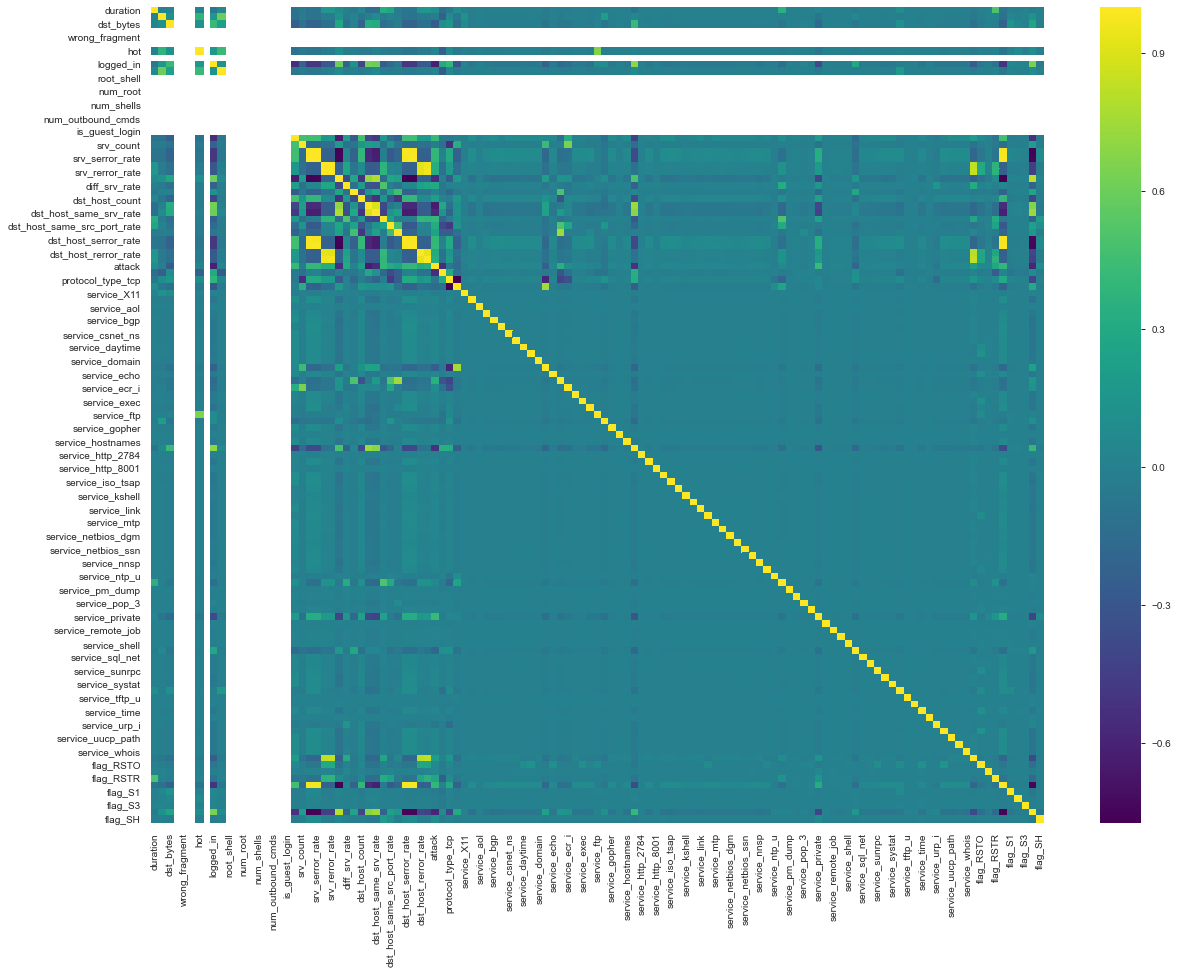

In [219]:
plt.subplots(figsize=(20, 15))
sns.heatmap(df_train_new.corr(), cmap="viridis")
plt.show()

# Dropping columns based on data summarisation and exploratory analysis.

- Based on low variance (near zero variance, can be seen in the correlation matrix and heat map.)
- High missings.
- High correlations between two numerical variables and removing variables which are not important for business context.

In [220]:
df_train_new.drop(columns=[
    'land', 'wrong_fragment', 'urgent', 'num_failed_logins', "root_shell",
    "su_attempted", "num_root", "num_file_creations", "num_shells",
    "num_access_files", "num_outbound_cmds", "is_host_login", "is_guest_login",
    'dst_host_rerror_rate', 'dst_host_serror_rate', 'dst_host_srv_rerror_rate',
    'dst_host_srv_serror_rate', 'num_root', 'num_outbound_cmds',
    'srv_rerror_rate', 'srv_serror_rate'
],
                  axis=1,
                  inplace=True)

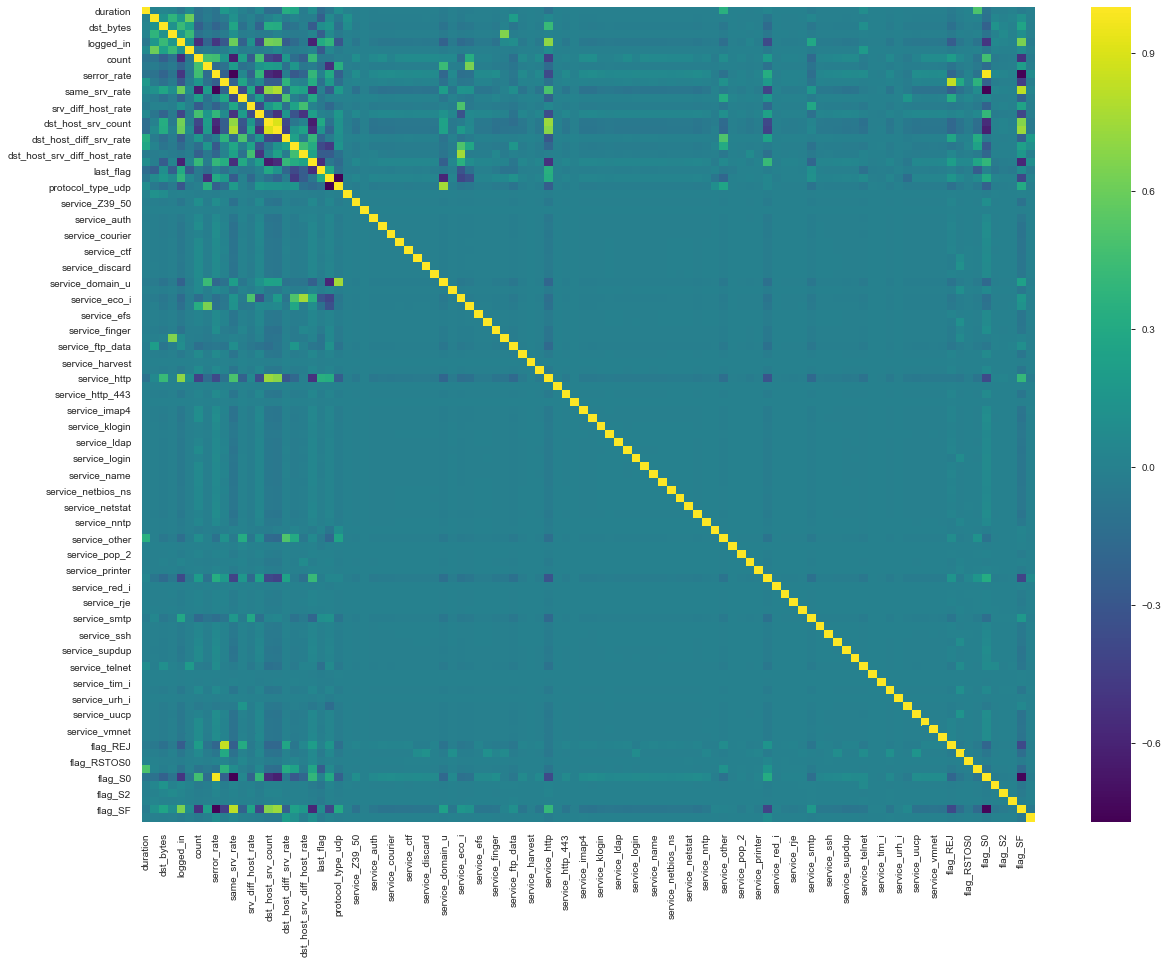

In [221]:
plt.subplots(figsize=(20, 15))
sns.heatmap(df_train_new.corr(), cmap="viridis")
plt.show()

In [222]:
#Saving the correlation matrix in an excel file.
corrm = df_train_new.corr()
corrm.to_excel('C:/Data Sets/(Class 21-Python - Case Study)/3. Network Intrusion Detection System/corr.xlsx')


## Feature selection using RFE

In [223]:
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression

#X = df_train_new[df_train_new.columns.difference(['attack'])]
feature_columns = df_train_new.columns.difference(['attack'])

logreg = LogisticRegression(solver='lbfgs')
rfe = RFE(logreg, n_features_to_select=20, verbose=10)

rfe = rfe.fit(df_train_new[feature_columns], df_train_new['attack'])

print(rfe.support_)
print(rfe.ranking_)

Fitting estimator with 101 features.


C:\Users\shaur\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Fitting estimator with 100 features.


C:\Users\shaur\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Fitting estimator with 99 features.


C:\Users\shaur\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Fitting estimator with 98 features.


C:\Users\shaur\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Fitting estimator with 97 features.


C:\Users\shaur\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Fitting estimator with 96 features.


C:\Users\shaur\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Fitting estimator with 95 features.


C:\Users\shaur\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Fitting estimator with 94 features.


C:\Users\shaur\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Fitting estimator with 93 features.


C:\Users\shaur\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Fitting estimator with 92 features.


C:\Users\shaur\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Fitting estimator with 91 features.


C:\Users\shaur\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Fitting estimator with 90 features.


C:\Users\shaur\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Fitting estimator with 89 features.


C:\Users\shaur\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Fitting estimator with 88 features.


C:\Users\shaur\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Fitting estimator with 87 features.


C:\Users\shaur\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Fitting estimator with 86 features.


C:\Users\shaur\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Fitting estimator with 85 features.


C:\Users\shaur\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Fitting estimator with 84 features.


C:\Users\shaur\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Fitting estimator with 83 features.


C:\Users\shaur\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Fitting estimator with 82 features.


C:\Users\shaur\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Fitting estimator with 81 features.


C:\Users\shaur\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Fitting estimator with 80 features.


C:\Users\shaur\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Fitting estimator with 79 features.


C:\Users\shaur\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Fitting estimator with 78 features.


C:\Users\shaur\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Fitting estimator with 77 features.


C:\Users\shaur\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Fitting estimator with 76 features.


C:\Users\shaur\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Fitting estimator with 75 features.


C:\Users\shaur\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Fitting estimator with 74 features.


C:\Users\shaur\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Fitting estimator with 73 features.


C:\Users\shaur\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Fitting estimator with 72 features.


C:\Users\shaur\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Fitting estimator with 71 features.


C:\Users\shaur\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Fitting estimator with 70 features.


C:\Users\shaur\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Fitting estimator with 69 features.


C:\Users\shaur\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Fitting estimator with 68 features.


C:\Users\shaur\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Fitting estimator with 67 features.


C:\Users\shaur\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Fitting estimator with 66 features.


C:\Users\shaur\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Fitting estimator with 65 features.


C:\Users\shaur\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Fitting estimator with 64 features.


C:\Users\shaur\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Fitting estimator with 63 features.


C:\Users\shaur\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Fitting estimator with 62 features.


C:\Users\shaur\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Fitting estimator with 61 features.


C:\Users\shaur\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Fitting estimator with 60 features.


C:\Users\shaur\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Fitting estimator with 59 features.


C:\Users\shaur\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Fitting estimator with 58 features.


C:\Users\shaur\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Fitting estimator with 57 features.


C:\Users\shaur\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Fitting estimator with 56 features.


C:\Users\shaur\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Fitting estimator with 55 features.


C:\Users\shaur\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Fitting estimator with 54 features.


C:\Users\shaur\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Fitting estimator with 53 features.


C:\Users\shaur\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Fitting estimator with 52 features.


C:\Users\shaur\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Fitting estimator with 51 features.


C:\Users\shaur\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Fitting estimator with 50 features.


C:\Users\shaur\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Fitting estimator with 49 features.


C:\Users\shaur\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Fitting estimator with 48 features.


C:\Users\shaur\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Fitting estimator with 47 features.


C:\Users\shaur\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Fitting estimator with 46 features.


C:\Users\shaur\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Fitting estimator with 45 features.


C:\Users\shaur\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Fitting estimator with 44 features.


C:\Users\shaur\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Fitting estimator with 43 features.


C:\Users\shaur\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Fitting estimator with 42 features.


C:\Users\shaur\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Fitting estimator with 41 features.


C:\Users\shaur\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Fitting estimator with 40 features.


C:\Users\shaur\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Fitting estimator with 39 features.


C:\Users\shaur\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Fitting estimator with 38 features.


C:\Users\shaur\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Fitting estimator with 37 features.


C:\Users\shaur\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Fitting estimator with 36 features.


C:\Users\shaur\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Fitting estimator with 35 features.


C:\Users\shaur\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Fitting estimator with 34 features.


C:\Users\shaur\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Fitting estimator with 33 features.


C:\Users\shaur\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Fitting estimator with 32 features.


C:\Users\shaur\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Fitting estimator with 31 features.


C:\Users\shaur\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Fitting estimator with 30 features.


C:\Users\shaur\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Fitting estimator with 29 features.


C:\Users\shaur\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Fitting estimator with 28 features.


C:\Users\shaur\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Fitting estimator with 27 features.


C:\Users\shaur\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Fitting estimator with 26 features.


C:\Users\shaur\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Fitting estimator with 25 features.


C:\Users\shaur\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Fitting estimator with 24 features.


C:\Users\shaur\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Fitting estimator with 23 features.


C:\Users\shaur\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Fitting estimator with 22 features.


C:\Users\shaur\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Fitting estimator with 21 features.


C:\Users\shaur\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[ True  True False  True  True  True False  True False  True False False
 False False  True False False False  True False False  True  True False
  True  True  True  True  True False False False False False False False
 False False False False False False  True False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False  True False False False False False False
 False False False False False False False False False False False False
 False False False  True  True]
[ 1  1 12  1  1  1  5  1  4  1  2 37 28  6  1 30 70 67  1 20 14  1  1 15
  1  1  1  1  1 62 26 79 23 35 22 43 46 48 47 66  8 57  1 11 29 31 19 17
  9 56 81 51  7 82 27 80 45 40 33 44 41 55 34 60 54 52 58 59 61 24 63 32
  3 76 75 25 71  1 73 68 69 74 10 64 65 53 42 50 18 78 77 49 72 16 21 36
 39 38 13  1  1]


C:\Users\shaur\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [224]:
X_final = df_train_new[feature_columns[rfe.support_]]
y_final = df_train_new['attack']

## Multi collinearity check - VIF

In [225]:
#Selecting significant variables
feature = df_train_new[feature_columns[rfe.support_]].columns

model_param = 'attack ~ ' + ' + '.join(feature)

In [226]:
# High VIF of the variable means information in that variable has already been explained by
# other X variables present in the model

# import the packages for vif
from statsmodels.stats.outliers_influence import variance_inflation_factor
from patsy import dmatrices

# separate the Y and X variables
y, X = dmatrices(model_param, df_train_new, return_type='dataframe')

# For each X, calculate VIF and save in dataframe
vif = pd.DataFrame()
vif['Features'] = X.columns
vif['VIF Factor'] = [
    variance_inflation_factor(X.values, i) for i in range(X.shape[1])
]

# display the output
features = list(
    vif.round(1).sort_values(by='VIF Factor', ascending=False).loc[:,
                                                                   'Features'])
features

vif


#Ideally VIF values more than 5 have a high multicollinearity. Ideally we should remove these variables for our analysis.

,Features,VIF Factor
0,Intercept,509.269446
1,count,4.906630
2,diff_srv_rate,1.882315
3,dst_host_count,1.880449
4,dst_host_diff_srv_rate,2.372098
5,dst_host_same_src_port_rate,2.320078
6,dst_host_srv_count,3.486624
7,duration,1.345695
8,flag_S0,31.196883
9,flag_SF,59.390693


In [227]:
#Removing the highly multicolinear variables

features_final = feature.difference(['flag_S0 ','flag_SF','logged_in','protocol_type_tcp','protocol_type_udf','rerror_rate','same_srv_rate','serror_rate'])
model_param_final = 'attack ~ ' + ' + '.join(features_final)

In [228]:
#VIF after removing the highly multicollinear variables

# High VIF of the variable means information in that variable has already been explained by
# other X variables present in the model
# separate the Y and X variables
y, X = dmatrices(model_param_final, df_train_new, return_type='dataframe')

# For each X, calculate VIF and save in dataframe
vif = pd.DataFrame()
vif['Features'] = X.columns
vif['VIF Factor'] = [
    variance_inflation_factor(X.values, i) for i in range(X.shape[1])
]

# display the output
features_final = list(
    vif.round(1).sort_values(by='VIF Factor', ascending=False).loc[:,
                                                                   'Features'])

vif

#We have ideal VIF's now in our dataset.

,Features,VIF Factor
0,Intercept,131.103510
1,count,3.038874
2,diff_srv_rate,1.489593
3,dst_host_count,1.745058
4,dst_host_diff_srv_rate,2.039042
5,dst_host_same_src_port_rate,2.080990
6,dst_host_srv_count,2.589369
7,duration,1.290143
8,flag_S0,2.373279
9,last_flag,1.404670


In [229]:
#features_final = features_final.remove('Intercept')
features_final.remove('Intercept')
features_final
#I have already removed intercept, but ran twice by mistake. Therefore, this error. Kindly ignore this error.

['count',
 'dst_host_srv_count',
 'srv_count',
 'flag_S0',
 'dst_host_same_src_port_rate',
 'dst_host_diff_srv_rate',
 'service_eco_i',
 'dst_host_count',
 'diff_srv_rate',
 'srv_diff_host_rate',
 'last_flag',
 'protocol_type_udp',
 'duration',
 'service_private']

In [230]:
#Final data for analysis

X = df_train_new[features_final]
y = df_train_new['attack']

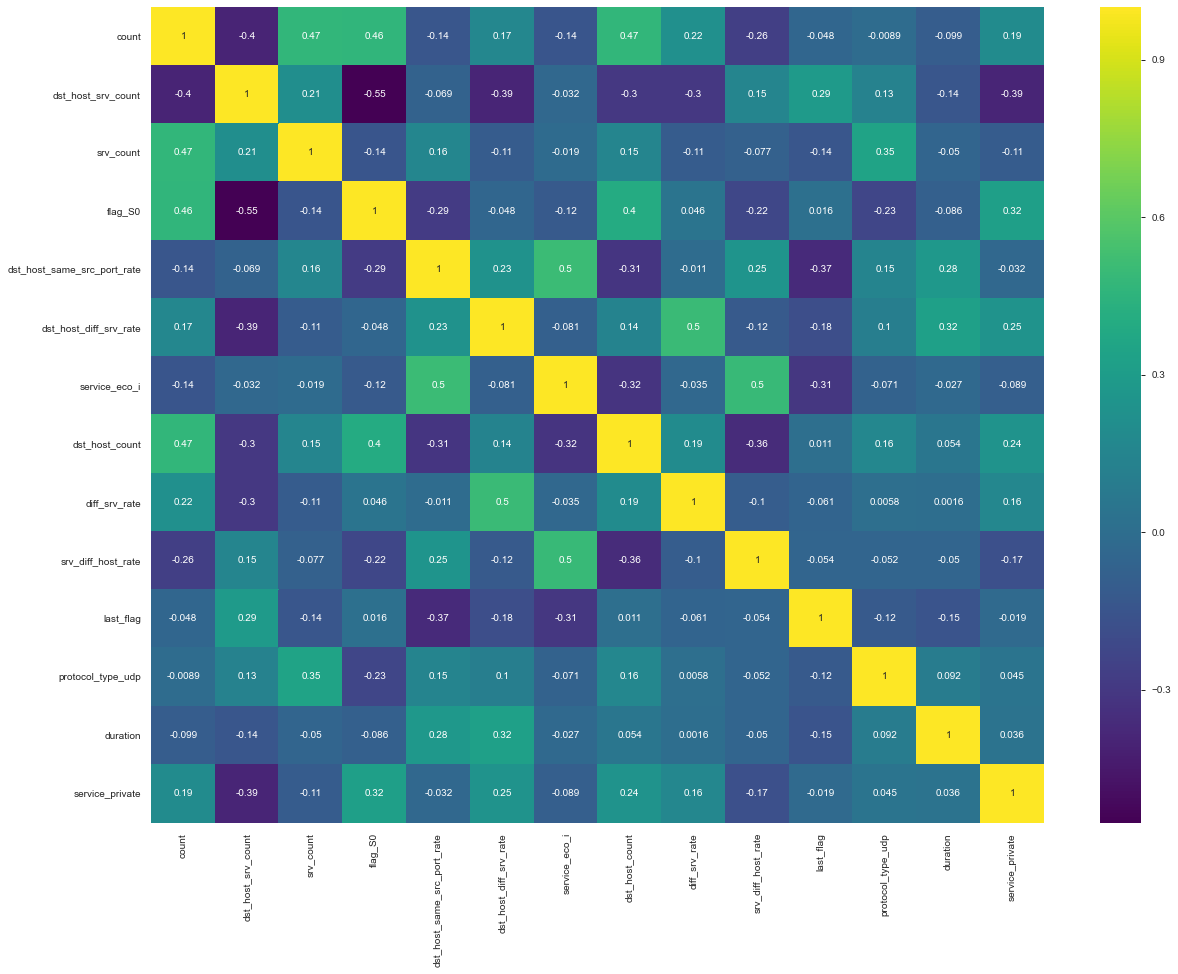

In [231]:
#Corelation check of the new variables

plt.subplots(figsize=(20, 15))
sns.heatmap(X.corr(), cmap="viridis", annot=True)
plt.show()

## Modelling and Predictions

In [232]:
from sklearn.model_selection import train_test_split

df_train_new[features_final]

train_X, test_X, train_y, test_y = train_test_split(X, y,test_size = 0.3, random_state = 12345)

## Building model from Statsmodels

In [233]:
# method 2: divide the data into training and testing for statsmodels.formula.api
train, test = train_test_split(df_train_new, test_size = 0.3, random_state = 12345)

In [234]:
# verify the no of obs in training and testing after split
print('No of obs in training: ', len(train), ' | ', 'No of obs in testing: ', len(test))

No of obs in training:  88181  |  No of obs in testing:  37792


In [235]:
import statsmodels.formula.api as smf

model_param_final = 'attack ~ ' + ' + '.join(features_final)
model_param_final

'attack ~ count + dst_host_srv_count + srv_count + flag_S0 + dst_host_same_src_port_rate + dst_host_diff_srv_rate + service_eco_i + dst_host_count + diff_srv_rate + srv_diff_host_rate + last_flag + protocol_type_udp + duration + service_private'

In [236]:
lr = smf.logit(formula = model_param_final, data = train).fit()

ValueError: endog must be in the unit interval.

### We get this error when we use y variable which has more than 2 values. This is a multinomial classification problem.

## Building model from sklearn

In [237]:
from sklearn.linear_model import LogisticRegression

logreg1 = LogisticRegression().fit(train_X,train_y)
logreg1.score(train_X,train_y)

C:\Users\shaur\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


0.8554677311438972

In [238]:
logreg1.intercept_

array([-0.00145662, -0.00281566,  0.00427228])

In [239]:
logreg1.predict(test_X)

array([1, 0, 1, ..., 1, 0, 0], dtype=int64)

In [240]:
y_pred = pd.DataFrame( { 'actual':  test_y,
                                'predicted': logreg1.predict( test_X) } )

In [241]:
print(metrics.accuracy_score( y_pred.actual, y_pred.predicted ))
print(metrics.roc_auc_score( y_pred.actual, y_pred.predicted, multi_class="ovr"))
#Getting an error with roc_auc_score, using multi_class "ovr" as well. Kindly advice.
#Good accuracy and ROC-AUC score of Test Data

0.8574566045723963


AxisError: axis 1 is out of bounds for array of dimension 1

Text(0.5, 12.5, 'Predicted label')

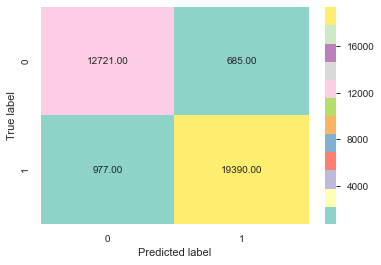

In [242]:
lr_cm = metrics.confusion_matrix(y_pred.predicted, y_pred.actual, [1, 0])
sns.heatmap(lr_cm,
            annot=True,
            cmap='Set3',
            fmt='.2f',
            )

plt.ylabel('True label')
plt.xlabel('Predicted label')

## Building the model from Random Forest Classifier for a better accuracy

In [243]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

rf1 = RandomForestClassifier(random_state=12345)
rf1.fit(train_X,train_y)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=12345,
                       verbose=0, warm_start=False)

In [244]:
rf1.score(train_X,train_y)
#We  get a 99.96% accuracy with the Random Forest Classifier model. This could probably be overfitting.

0.9996597906578515

In [245]:
rf1.predict(test_X)

array([1, 0, 1, ..., 2, 0, 0], dtype=int64)

In [246]:
y_pred1 = pd.DataFrame( { 'actual':  test_y,
                                'predicted': rf1.predict( test_X) } )

In [247]:
y_pred1

,actual,predicted
112168,1,1
66607,0,0
108068,1,1
81121,1,1
31292,1,1
...,...,...
80385,2,2
120029,1,1
3457,2,2
62256,0,0


In [248]:
print(metrics.accuracy_score(y_pred.actual, y_pred1.predicted))
#print(metrics.roc_auc_score(y_pred.actual, y_pred1.predicted, multi_class = 'ovr'))

#Better accuracy of Test Data from Logistic Regression

0.9970628704487722


Text(0.5, 12.5, 'Predicted label')

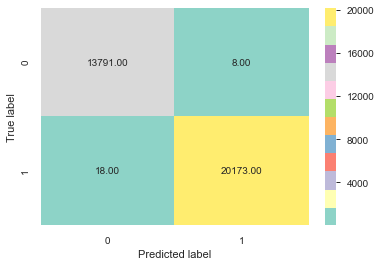

In [249]:
rftree_cm = metrics.confusion_matrix(y_pred1.predicted, y_pred.actual, [1, 0])
sns.heatmap(rftree_cm,
            annot=True,
            cmap='Set3',
            fmt='.2f',
            )

plt.ylabel('True label')
plt.xlabel('Predicted label')

## Implementing Grid Search CV to get a better score and reduce overfitting and reduce multicollinearity (if any).

In [250]:
param_grid = {
    'n_estimators': [70, 80, 90, 100, 120, 150, 200],
    'max_features': [5, 6, 7, 8, 9, 10],
}

rgscv = GridSearchCV(RandomForestClassifier(random_state=12345),
                     param_grid,
                     cv=10,
                     verbose=10,
                     n_jobs=-1)

rgscv.fit(train_X, train_y)

Fitting 10 folds for each of 42 candidates, totalling 420 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   10.3s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   18.7s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:   21.8s
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   38.3s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   52.4s
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done  97 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:  3.2min
[Parallel(n_jobs=-1)]: Done 129 tasks      | elapsed:  3.8min
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:  4.5min
[Parallel(n_jobs=-1)]: Done 165 tasks      | elapsed:  5.0min
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  5

GridSearchCV(cv=10, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=None,
                                              oob_score=False,
                                              rand

In [251]:
rgscv.best_params_

{'max_features': 6, 'n_estimators': 120}

In [252]:
rgscv.best_score_

#99.7% score

0.9970288445808322

In [253]:
rgscv.predict(test_X)

array([1, 0, 1, ..., 2, 0, 0], dtype=int64)

In [254]:
y_pred2 = pd.DataFrame( { 'actual':  test_y,
                                'predicted': rgscv.predict( test_X) } )

In [255]:
print(metrics.accuracy_score(y_pred.actual, y_pred2.predicted))
#print(metrics.roc_auc_score(y_pred.actual, y_pred2.predicted))

#Better score than a single Random Forest Classifier

0.9969305673158341


Text(0.5, 12.5, 'Predicted label')

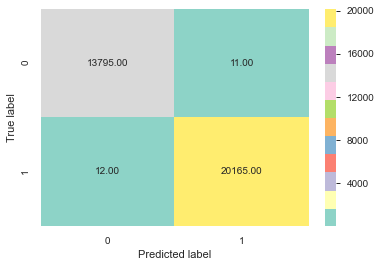

In [256]:
rfgsv_cm = metrics.confusion_matrix(y_pred2.predicted, y_pred.actual, [1, 0])
sns.heatmap(rfgsv_cm,
            annot=True,
            cmap='Set3',
            fmt='.2f',
            )

plt.ylabel('True label')
plt.xlabel('Predicted label')

## Running Boosting Methods to test the accuracy and ROC score of the models.

In [257]:
from sklearn.ensemble import GradientBoostingClassifier

pargrid_grad = {'n_estimators': [50, 70, 90, 100, 200],
                   'learning_rate': [10 ** x for x in range(-3, 1)]}

gscv_grad = GridSearchCV(estimator = GradientBoostingClassifier(), 
                        param_grid = pargrid_grad, 
                        cv = 5,
                        verbose = True, 
                        n_jobs = -1)

gscv_grad.fit(train_X,train_y)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  2.8min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  9.0min finished


GridSearchCV(cv=5, error_score=nan,
             estimator=GradientBoostingClassifier(ccp_alpha=0.0,
                                                  criterion='friedman_mse',
                                                  init=None, learning_rate=0.1,
                                                  loss='deviance', max_depth=3,
                                                  max_features=None,
                                                  max_leaf_nodes=None,
                                                  min_impurity_decrease=0.0,
                                                  min_impurity_split=None,
                                                  min_samples_leaf=1,
                                                  min_samples_split=2,
                                                  min_weight_fraction_leaf=0.0,
                                                  n_estimators=100,
                                                  n_iter_no_change=None,
         

In [258]:
gscv_grad.best_params_

{'learning_rate': 1, 'n_estimators': 70}

In [259]:
gscv_grad.predict(test_X)

array([1, 0, 0, ..., 2, 0, 0], dtype=int64)

In [260]:
y_pred3 = pd.DataFrame( { 'actual':  test_y,
                                'predicted': gscv_grad.predict( test_X) } )

In [261]:
y_pred3

,actual,predicted
112168,1,1
66607,0,0
108068,1,0
81121,1,1
31292,1,1
...,...,...
80385,2,2
120029,1,1
3457,2,2
62256,0,0


In [262]:
print(metrics.accuracy_score(y_pred.actual, y_pred3.predicted))
#print(metrics.roc_auc_score(y_pred.actual, y_pred3.predicted))

0.9957133784928027


Text(0.5, 12.5, 'Predicted label')

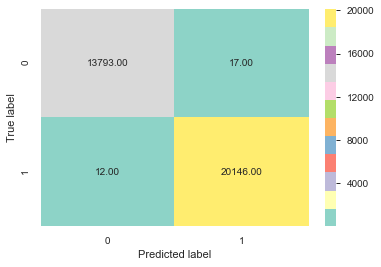

In [269]:
grad_cm = metrics.confusion_matrix(y_pred3.predicted, y_pred.actual, [1, 0])
sns.heatmap(
    grad_cm,
    annot=True,
    cmap='Set3',
    fmt='.2f',
)

plt.ylabel('True label')
plt.xlabel('Predicted label')

## Running the Model with Artificial Neural Networks

In [264]:
import tensorflow as tf

In [265]:
#Initializing the neural network
ann = tf.keras.models.Sequential()

In [266]:
#Adding the first hidden layer
ann.add(tf.keras.layers.Dense(units = 8, activation = 'softmax'))
        
# Adding the second hidden layer
ann.add(tf.keras.layers.Dense(units = 8, activation = 'softmax'))

# Adding the third layer
ann.add(tf.keras.layers.Dense(units = 6, activation = 'softmax'))

# Adding the output layer
ann.add(tf.keras.layers.Dense(units = 4, activation = 'sigmoid'))  #units = N-1 for multinomial classification

In [267]:
#Compiling the ANN

ann.compile(optimizer = 'adam', loss = 'kullback_leibler_divergence', weighted_metrics = ['accuracy'])

In [270]:
#Fitting our Model

ann.fit(train_X.values,train_y.values, batch_size= 10, epochs= 30)

Train on 88181 samples
Epoch 1/30
88181/88181 [==============================] - 7s 80us/sample - loss: 0.0822 - accuracy: 0.0000e+00
Epoch 2/30
88181/88181 [==============================] - 7s 79us/sample - loss: 4.1818e-04 - accuracy: 0.0000e+00
Epoch 3/30
88181/88181 [==============================] - 7s 79us/sample - loss: 3.3433e-06 - accuracy: 0.2235
Epoch 4/30
88181/88181 [==============================] - 7s 81us/sample - loss: -3.3312e-06 - accuracy: 0.9596
Epoch 5/30
88181/88181 [==============================] - 7s 79us/sample - loss: -3.4455e-06 - accuracy: 1.0000
Epoch 6/30
88181/88181 [==============================] - 7s 76us/sample - loss: -3.4455e-06 - accuracy: 1.0000
Epoch 7/30
88181/88181 [==============================] - 7s 76us/sample - loss: -3.4455e-06 - accuracy: 1.0000
Epoch 8/30
88181/88181 [==============================] - 7s 76us/sample - loss: -3.4455e-06 - accuracy: 1.0000
Epoch 9/30
88181/88181 [==============================] - 7s 77us/sample - loss:

In [271]:
# Predicting the Test set results
y_pred = ann.predict(test_X)
y_pred = (y_pred > 0.2)   #---using response rate for quick estimation of optimal cut-off

Case of overfitting with the ANN's as we are getting a perfect score.

We have the best score with Random Forest Classifier which ran with Grid Search CV.
We will use those predicted values for our analysis.

## Predictions

In [272]:
# Step 4: predict the spend on the testing/validation data
test_X['Predictions'] = rgscv.predict(test_X)

#I have already run this code and Predictions column came up. This error came because Predictions is already there and there is one column more.

C:\Users\shaur\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [273]:
test = pd.concat([test_X, test_y], axis =1)

In [274]:
test[['attack','Predictions']]

,attack,Predictions
112168,1,1
66607,0,0
108068,1,1
81121,1,1
31292,1,1
...,...,...
80385,2,2
120029,1,1
3457,2,2
62256,0,0


In [275]:
##Predicting the y variable on the new test dataset

testX = df_test_new[features_final]
testy = df_test_new['attack']

In [276]:
rgscv.fit(testX,testy)  #Random Forest Classifier which we ran before to test our accuracies where we got 99.4% accuracy.

Fitting 10 folds for each of 42 candidates, totalling 420 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    3.6s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    5.0s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    5.6s
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    8.6s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   10.9s
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:   14.2s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:   17.8s
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:   23.7s
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:   27.2s
[Parallel(n_jobs=-1)]: Done  97 tasks      | elapsed:   31.1s
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:   36.3s
[Parallel(n_jobs=-1)]: Done 129 tasks      | elapsed:   44.4s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:   51.9s
[Parallel(n_jobs=-1)]: Done 165 tasks      | elapsed:   57.4s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  1

GridSearchCV(cv=10, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=None,
                                              oob_score=False,
                                              rand

In [277]:
rgscv.best_score_

0.9908179398241511

In [278]:
rgscv.best_params_

{'max_features': 9, 'n_estimators': 80}

In [279]:
testX['Predictions'] = rgscv.predict(testX)

C:\Users\shaur\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [280]:
testnew = pd.concat([testX, testy], axis =1)

In [281]:
testnew[['attack','Predictions']]

,attack,Predictions
0,1,1
1,1,1
2,0,0
3,2,2
4,2,2
...,...,...
22539,0,0
22540,0,0
22541,1,1
22542,0,0


In [286]:
print('The accuracy score with the Random Forest Classifier with test data',
      metrics.accuracy_score(y_pred2.actual, y_pred2.predicted))
#print('The accuracy score with the Random Forest Classifier with test data',
#metrics.roc_auc_score(y_pred.actual, y_pred2.predicted))

print(
    'The accuracy score with the Random Forest Classifier with the new test data',
    metrics.accuracy_score(testnew.attack, testnew.Predictions))
#print(
# 'The accuracy score with the Random Forest Classifier with the new test data',
# metrics.roc_auc_score(testnew.attack, testnew.Predictions))

The accuracy score with the Random Forest Classifier with test data 0.9969305673158341
The accuracy score with the Random Forest Classifier with the new test data 0.9992459190915542


In [302]:
testnew.to_excel('C:/Data Sets/(Class 21-Python - Case Study)/3. Network Intrusion Detection System/Final Predictions with the test data.xlsx')

#Final Predictions saved in an excel file.

## Conclusions 

The accuracies with all the models have been very high, which might be a case of a little overfitting. We have throughly worked on hyperparameter tuning and regularisation using many hyperparameter tuning models.
Also the test data have been very accrate(close to train data) so the problem of overfitting has been nullified a lot.
We had already tested with many variables to find the significant variables to reduce multicollinearity.
The predicted values have been also saved with the test data given in the case study.

## If there are any challenges/remarks in the case study analysis, kindly let me know so I can improve myself on my mistakes just like these Machine Learning Models. :D 

## Thank You!